In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

from IPython import display
import math
import pandas as pd
import numpy as np

from pyspark.sql import SQLContext
from pyspark import SparkContext

from pyspark.sql.types import *

In [ ]:
sc =SparkContext( )
sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
customSchema = StructType([
    StructField("clean_text", StringType()), 
    StructField("category", StringType())])

In [ ]:
filename1 = '/content/drive/MyDrive/BDMA/twitter.csv'
filename2 = '/content/drive/MyDrive/BDMA/reddit.csv'

In [ ]:
df1 = sqlContext.read.format("csv").option("header", "true").schema(customSchema).load(filename1)
df1.count()

612

In [ ]:
df2 = sqlContext.read.format("csv").option("header", "true").schema(customSchema).load(filename2)
df2.count()

989

In [ ]:
df = df1.union(df2)
df.count() 

1601

In [ ]:
data = df.na.drop(how='any')
data.show(5)

+--------------------+--------+
|          clean_text|category|
+--------------------+--------+
|soon money leaves...|       0|
|comments returned...|       0|
|even finally find...|       1|
|comments returned...|       1|
|comments returned...|       1|
+--------------------+--------+
only showing top 5 rows



In [ ]:
data.printSchema()

root
 |-- clean_text: string (nullable = true)
 |-- category: string (nullable = true)



*Model Pipeline*

In [ ]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="clean_text", outputCol="words", pattern="\\W")

# stop words
add_stopwords = ["http","https","amp","rt","t","c","the"] 

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=20000, minDF=5)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")

pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)

+--------------------+--------+--------------------+--------------------+--------------------+-----+
|          clean_text|category|               words|            filtered|            features|label|
+--------------------+--------+--------------------+--------------------+--------------------+-----+
|                 ...|       0|[is, so, sad, for...|[is, so, sad, for...|(13391,[7,8,10,17...|  1.0|
|                 ...|       0|[i, missed, the, ...|[i, missed, new, ...|(13391,[0,107,268...|  1.0|
|              omg...|       1|[omg, its, alread...|[omg, its, alread...|(13391,[85,205,26...|  0.0|
|          .. Omga...|       0|[omgaga, im, sooo...|[omgaga, im, sooo...|(13391,[0,4,16,20...|  1.0|
|         i think ...|       0|[i, think, mi, bf...|[i, think, mi, bf...|(13391,[0,10,13,1...|  1.0|
+--------------------+--------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



*Partition Training & Test sets & Model Training and Evaluation*

In [ ]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 70679
Test Dataset Count: 30283


In [ ]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0).select("clean_text","category","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|#andyhurleyday #andyhurleyd...|       1|[0.9996523847736428,2.38449...|  0.0|       0.0|
|@ the llama exhibit my son ...|       1|[0.9989295033734265,9.01622...|  0.0|       0.0|
|what having voices your hea...|       1|[0.9976879400610135,4.20526...|  0.0|       0.0|
|..i'm ink'd up..ink'd-ink'd...|       1|[0.9961368424691744,0.00356...|  0.0|       0.0|
|@CHRISDJMOYLES Strictly Com...|       1|[0.9951054798348982,0.00446...|  0.0|       0.0|
|@archukat what do you mean ...|       1|[0.9949477128218247,0.00455...|  0.0|       0.0|
| thought about occasionally...|       1|[0.9947389517405888,0.00157...|  0.0|       0.0|
|@apunbindaas More, much mor...|       1|[0.9946376961485853,0.00486...|  0.0|       0.0|
|@__Parasi

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.7359493119644521

Cross Validation


In [ ]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             #.addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
             #.addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
lrAccuracy=evaluator.evaluate(predictions)

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1)
nbModel = nb.fit(trainingData)
predictions = nbModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|@armybrat4life1 Get 100 fol...|       1|[0.9999999981121803,1.88781...|  0.0|       0.0|
|@annmaryen Get 100 follower...|       1|[0.9999999981121803,1.88781...|  0.0|       0.0|
|@casinojack Get 100 followe...|       1|[0.9999999981121803,1.88781...|  0.0|       0.0|
|@caramellov4u Get 100 follo...|       1|[0.9999999981121803,1.88781...|  0.0|       0.0|
|@arya_johari Get 100 follow...|       1|[0.9999999981121803,1.88781...|  0.0|       0.0|
|@cleeboyyy Get 100 follower...|       1|[0.9999999981121803,1.88781...|  0.0|       0.0|
|@crittersize Get 100 follow...|       1|[0.9999999981121803,1.88781...|  0.0|       0.0|
|@crystalized09 Get 100 foll...|       1|[0.9999999981121803,1.88781...|  0.0|       0.0|
|@chanaluv

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
nbAccuracy = evaluator.evaluate(predictions)
print(nbAccuracy)

0.7492413344386659


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                    clean_text|category|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|@_crayegg Get 100 followers...|       1|[0.6282846411241865,0.36833...|  0.0|       0.0|
|@brand2930420 Get 100 follo...|       1|[0.6282846411241865,0.36833...|  0.0|       0.0|
|@cleowantsalext Get 100 fol...|       1|[0.6282846411241865,0.36833...|  0.0|       0.0|
|@cookiebaby Get 100 followe...|       1|[0.6282846411241865,0.36833...|  0.0|       0.0|
|@anna_banana25 Get 100 foll...|       1|[0.6282846411241865,0.36833...|  0.0|       0.0|
|@christlikegirl Get 100 fol...|       1|[0.6282846411241865,0.36833...|  0.0|       0.0|
|@crazy_k09 Get 100 follower...|       1|[0.6282846411241865,0.36833...|  0.0|       0.0|
|@chaserman911 Get 100 follo...|       1|[0.6282846411241865,0.36833...|  0.0|       0.0|
|@applecri

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rfAccuracy = evaluator.evaluate(predictions)
print(rfAccuracy) 

0.4055776969734774


In [ ]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)


ovr = OneVsRest(classifier=lr)

ovrModel = ovr.fit(trainingData)

# score the model on test data.
predictions = ovrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("clean_text","category","label","prediction") \
    .show(n = 10, truncate = 30)


+------------------------------+--------+-----+----------+
|                    clean_text|category|label|prediction|
+------------------------------+--------+-----+----------+
|                     FUCK YOU!|       0|  1.0|       0.0|
|          i want some ben&a...|       0|  1.0|       0.0|
|         or i just worry to...|       0|  1.0|       0.0|
|       Hardest working chic...|       1|  0.0|       0.0|
|       Juuuuuuuuuuuuuuuuuss...|       1|  0.0|       0.0|
|      I must think about po...|       0|  1.0|       0.0|
|            what the hell BBC?|       0|  1.0|       0.0|
|                      #canucks|       0|  1.0|       0.0|
|     &lt;- but mustache man...|       0|  1.0|       0.0|
|     @riceuniversiity I kno...|       0|  1.0|       0.0|
+------------------------------+--------+-----+----------+
only showing top 10 rows



In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
ovrAccuracy = evaluator.evaluate(predictions)
print(ovrAccuracy)

0.7278688038734377


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
model = ['Logistic regression', 'Naive Bayes', 'Random Forest', 'OneVsRest']
accuracy = [lrAccuracy,nbAccuracy,rfAccuracy, ovrAccuracy]

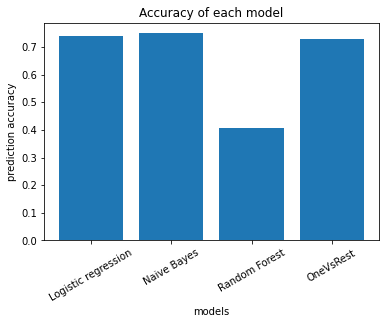

In [ ]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(model))
    plt.bar(index, accuracy)
    plt.xlabel('models', fontsize=10)
    plt.ylabel('prediction accuracy', fontsize=10)
    plt.xticks(index, model, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()
    
plot_bar_x()